# OpenET GEESEBAL
## Collection "Overpass" Examples

In [1]:
import datetime
import pprint

import ee
import pandas as pd

from IPython.display import Image
import openet.geesebal as model

In [2]:
ee.Initialize()

In [3]:
ndvi_palette = ['#EFE7E1', '#003300']
et_palette = [
    'DEC29B', 'E6CDA1', 'EDD9A6', 'F5E4A9', 'FFF4AD', 'C3E683', '6BCC5C', 
    '3BB369', '20998F', '1C8691', '16678A', '114982', '0B2C7A']

In [4]:
image_size = 768
landsat_cs = 30

## Input parameters

In [5]:
collections = ['LANDSAT/LC08/C02/T1_L2']

et_reference_source = 'IDAHO_EPSCOR/GRIDMET'
et_reference_band = 'eto'
et_reference_factor = 1
et_reference_resample = 'nearest'

# Date range you want to aggregate ET over
# End date is exclusive (like .filterDate() calls)
start_date = '2017-07-01'
end_date = '2017-08-01'

# Only keep images with an average cloud cover less than
# Cloud cover filter parameter is not being passed in (yet)
cloud_cover = 70

# Number of extra days (at start and end) to include in interpolation
interp_days = 32
# Interpolation method - currently only LINEAR is supported
interp_method = 'LINEAR'

# Hard code the study area and CRS to the test point
# The region must be quite small in order to not have GEE memory errors or time outs
test_xy = [-121.5265, 38.7399]
test_point = ee.Geometry.Point(test_xy)
study_area = ee.Geometry.Rectangle(
    test_xy[0] - 0.2, test_xy[1] - 0.1, test_xy[0] + 0.2, test_xy[1] + 0.1
)
region = study_area.bounds(1, 'EPSG:4326').coordinates().getInfo()
crs = 'EPSG:32610'

## Landsat 8 Collection 2 Level 2 (Surface Reflectance) Image Collection

In [6]:
model_obj = model.Collection(
    collections=collections,
    start_date=start_date,
    end_date=end_date,
    geometry=test_point,
    cloud_cover_max=70,
    model_args={
        'et_reference_source': et_reference_source, 
        'et_reference_band': et_reference_band,
        'et_reference_factor': et_reference_factor,
        'et_reference_resample': et_reference_resample,
    },
    # filter_args={},
)
pprint.pprint(model_obj.get_image_ids())

['LANDSAT/LC08/C02/T1_L2/LC08_044033_20170716']


In [7]:
def get_region_df(info):
    """Convert the output of getRegions to a pandas dataframe"""
    col_dict = {}
    info_dict = {}
    for i, k in enumerate(info[0][4:]):
        col_dict[k] = i+4
        info_dict[k] = {}
        
    for row in info[1:]:
        date = datetime.datetime.utcfromtimestamp(row[3] / 1000.0).strftime('%Y-%m-%d')
        for k, v in col_dict.items():
            info_dict[k][date] = row[col_dict[k]]
            
    return pd.DataFrame.from_dict(info_dict).sort_index()

## "Overpass" Collection

In [8]:
overpass_coll = model_obj.overpass(variables=['ndvi', 'et', 'et_fraction'])

In [9]:
overpass_df = get_region_df(overpass_coll.getRegion(test_point, scale=30).getInfo())
pprint.pprint(overpass_df)
print('')
pprint.pprint(overpass_df[['et']].sum())

                ndvi        et  et_fraction
2017-07-16  0.847217  7.271613     0.876098

et    7.271613
dtype: float64


## NDVI

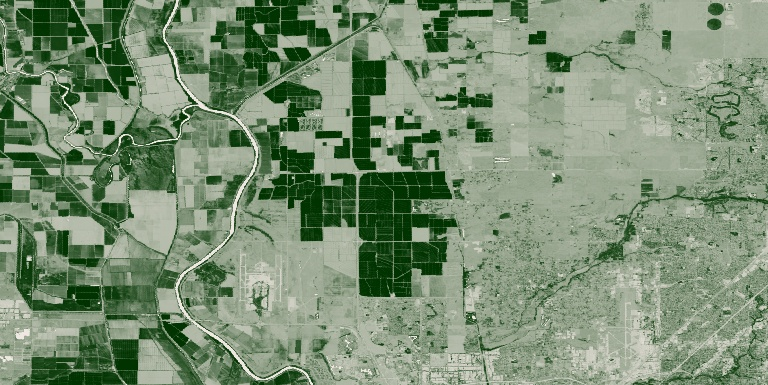

In [10]:
image_url = (
    ee.Image(overpass_coll.select(['ndvi']).mean())
    #.reproject(crs=crs, scale=120)
    .getThumbURL({'min': -0.1, 'max': 0.9, 'palette': ','.join(ndvi_palette), 'region': region, 'dimensions': image_size})
)
Image(image_url, embed=True, format='png')

## ET

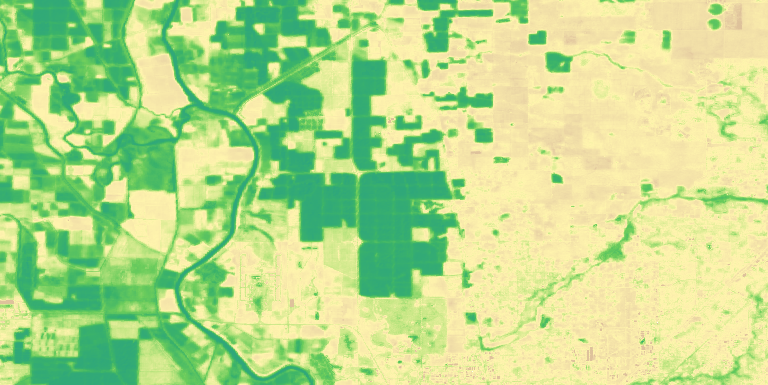

In [11]:
image_url = (
    ee.Image(overpass_coll.select(['et']).mean())
    #.reproject(crs=crs, scale=120)
    .getThumbURL({'min': 0.0, 'max': 12, 'palette': ','.join(et_palette), 'region': region, 'dimensions': image_size})
)
Image(image_url, embed=True, format='png')

## ET fraction

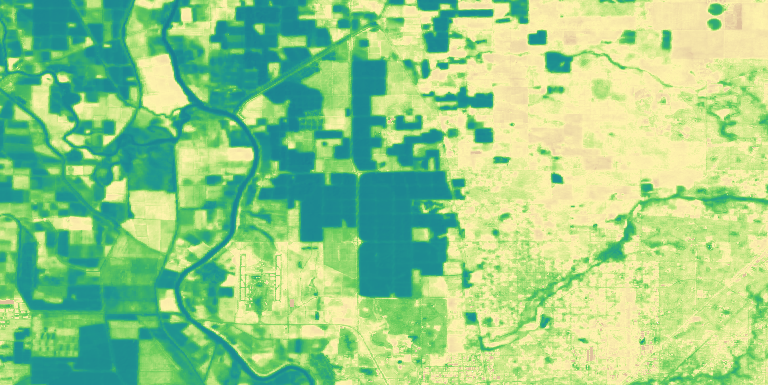

In [12]:
image_url = (
    ee.Image(overpass_coll.select(['et_fraction']).mean())
    #.reproject(crs=crs, scale=120)
    .getThumbURL({'min': 0.0, 'max': 1.2, 'palette': et_palette, 'region': region, 'dimensions': image_size})
)
Image(image_url, embed=True, format='png')